In [1]:
import pandas as pd
import datetime
import numpy as np
from mido import Message, MidiFile, MidiTrack, MetaMessage
import music21
from collections import namedtuple

## Data processing: 

In [2]:
df = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv')
df

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source
0,Afghanistan,AFG,Asia,38928341,cases,0,2020-01,NaN,0,"Epidemic intelligence, national weekly data"
1,Afghanistan,AFG,Asia,38928341,cases,0,2020-02,0.000000,0,"Epidemic intelligence, national weekly data"
2,Afghanistan,AFG,Asia,38928341,cases,0,2020-03,0.000000,0,"Epidemic intelligence, national weekly data"
3,Afghanistan,AFG,Asia,38928341,cases,0,2020-04,0.000000,0,"Epidemic intelligence, national weekly data"
4,Afghanistan,AFG,Asia,38928341,cases,0,2020-05,0.000000,0,"Epidemic intelligence, national weekly data"
...,...,...,...,...,...,...,...,...,...,...
32967,Zimbabwe,ZWE,Africa,14862927,deaths,142,2021-26,13.859989,1878,"Epidemic intelligence, national weekly data"
32968,Zimbabwe,ZWE,Africa,14862927,deaths,307,2021-27,30.209393,2185,"Epidemic intelligence, national weekly data"
32969,Zimbabwe,ZWE,Africa,14862927,deaths,437,2021-28,50.057435,2622,"Epidemic intelligence, national weekly data"
32970,Zimbabwe,ZWE,Africa,14862927,deaths,472,2021-29,61.158882,3094,"Epidemic intelligence, national weekly data"


In [3]:
df['date'] = pd.to_datetime([datetime.datetime.strptime(d + '-1', '%G-%V-%u') for d in df['year_week']])

In [4]:
df_cases = df.loc[df['indicator'] == 'cases', ['country', 'country_code', 'date', 'weekly_count', 'cumulative_count']].rename(columns = {
    'weekly_count': 'weekly_cases', 
    'cumulative_count': 'cumulative_cases'
})

In [5]:
df_deaths = df.loc[df['indicator'] == 'deaths', ['country', 'country_code', 'date', 'weekly_count', 'cumulative_count']].rename(columns = {
    'weekly_count': 'weekly_deaths', 
    'cumulative_count': 'cumulative_deaths'
})

In [6]:
df_weekly = pd.merge(df_cases, df_deaths, on=['country', 'country_code', 'date'])
df_weekly

,country,country_code,date,weekly_cases,cumulative_cases,weekly_deaths,cumulative_deaths
0,Afghanistan,AFG,2019-12-30,0,0,0,0
1,Afghanistan,AFG,2020-01-06,0,0,0,0
2,Afghanistan,AFG,2020-01-13,0,0,0,0
3,Afghanistan,AFG,2020-01-20,0,0,0,0
4,Afghanistan,AFG,2020-01-27,0,0,0,0
...,...,...,...,...,...,...,...
16481,Zimbabwe,ZWE,2021-06-28,8032,54474,142,1878
16482,Zimbabwe,ZWE,2021-07-05,13291,67765,307,2185
16483,Zimbabwe,ZWE,2021-07-12,15854,83619,437,2622
16484,Zimbabwe,ZWE,2021-07-19,14275,97894,472,3094


In [7]:
continent_names_df = pd.read_csv(
    './data/bbc_world_v2_4326_centroid_region.csv'
)

continent_df = pd.merge(df_weekly, 
         continent_names_df[['iso3', 'bbc-region-code']], 
         left_on = 'country_code', 
         right_on = 'iso3').groupby(
    ['date', 'bbc-region-code']
)[['weekly_cases', 'weekly_deaths']].sum().reset_index()

def rename_continent(bbc_region): 
    switcher = {
        'region_as': 'Asia',
        'region_af': 'Africa',
        'region_am_na': 'North America',
        'region_am_lac': 'Latin America',
        'region_me': 'Middle East',
        'region_eu': 'Europe',
        'region_oc': 'Oceania'
    }
    return switcher[bbc_region]

continent_df['name'] = continent_df['bbc-region-code'].map(rename_continent)
continent_df = continent_df[['date', 'name', 'weekly_cases', 'weekly_deaths']]

continent_df = continent_df.sort_values(by = ['name', 'date']).reset_index(drop=True)
# continent_df['cases_rolling_average'] = continent_df.groupby(
#     'continent_name'
# ).rolling(7)['cases'].mean().reset_index(drop=True)
# continent_df['deaths_rolling_average'] = continent_df.groupby(
#     'continent_name'
# ).rolling(7)['deaths'].mean().reset_index(drop=True)
continent_df['cumulative_deaths'] = continent_df.groupby(['name'])['weekly_deaths'].cumsum()

In [8]:
continent_df

,date,name,weekly_cases,weekly_deaths,cumulative_deaths
0,2019-12-30,Africa,0,0,0
1,2020-01-06,Africa,0,0,0
2,2020-01-13,Africa,0,0,0
3,2020-01-20,Africa,0,0,0
4,2020-01-27,Africa,0,0,0
...,...,...,...,...,...
576,2021-06-28,Oceania,3660,22,1439
577,2021-07-05,Oceania,4940,29,1468
578,2021-07-12,Oceania,7867,68,1536
579,2021-07-19,Oceania,4432,58,1594


In [9]:
individual_countries = ['China', 
                        'India', 
                        'South Africa', 
                        'Italy', 
                        'United Kingdom', 
                        'Brazil', 
                        'United States Of America']
individual_countries_df = df_weekly.loc[df_weekly['country'].isin(individual_countries)]
individual_countries_df.rename(columns = {'country': 'name'}, inplace = True)
individual_countries_df = individual_countries_df[
    ['date', 'name', 'weekly_cases', 'weekly_deaths', 'cumulative_deaths']
]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [10]:
individual_countries_df

,date,name,weekly_cases,weekly_deaths,cumulative_deaths
2294,2019-12-30,Brazil,0,0,0
2295,2020-01-06,Brazil,0,0,0
2296,2020-01-13,Brazil,0,0,0
2297,2020-01-20,Brazil,0,0,0
2298,2020-01-27,Brazil,0,0,0
...,...,...,...,...,...
15748,2021-06-28,United States Of America,92182,1559,605526
15749,2021-07-05,United States Of America,138400,1637,607163
15750,2021-07-12,United States Of America,256273,1990,609153
15751,2021-07-19,United States Of America,332523,1739,610892


In [11]:
continent_df

,date,name,weekly_cases,weekly_deaths,cumulative_deaths
0,2019-12-30,Africa,0,0,0
1,2020-01-06,Africa,0,0,0
2,2020-01-13,Africa,0,0,0
3,2020-01-20,Africa,0,0,0
4,2020-01-27,Africa,0,0,0
...,...,...,...,...,...
576,2021-06-28,Oceania,3660,22,1439
577,2021-07-05,Oceania,4940,29,1468
578,2021-07-12,Oceania,7867,68,1536
579,2021-07-19,Oceania,4432,58,1594


In [12]:
continent_and_countries_df = pd.concat([continent_df, individual_countries_df])

In [18]:
Note = namedtuple('Note', ['pitch', 'duration', 'accent'])
Note.__new__.__defaults__ = (None,) * len(Note._fields)
Part = namedtuple('Part', 'notes')
Phrase = namedtuple('Phrase', 'parts')

stac = music21.articulations.Staccato()
acc = music21.articulations.Accent()

phrase_1 = Phrase([Part([Note(69, 4), Note(69, 1)]),
                   Part([Note(62, 4), Note(60, 1)]), 
                   Part([Note(53, 4), Note(52, 1)]), 
                   Part([Note(43, 4), Note(43, 1)])])

phrase_2 = Phrase([Part([Note(70, 2), Note(74, 2, 'accent'), Note(70, 1)]),
                   Part([Note(62, 2), Note(62, 2, 'accent'), Note(62, 1)]), 
                   Part([Note(53, 2), Note(53, 2, 'accent'), Note(53, 1)]), 
                   Part([Note(43, 2), Note(46, 2, 'accent'), Note(43, 1)])])

phrase_3 = Phrase([Part([Note(70, 1, 'stac'), Note(69, 1, 'stac'), Note(67, 1, 'stac'), Note(69, 2)]),
                   Part([Note(62, 1, 'stac'), Note(62, 1, 'stac'), Note(62, 1, 'stac'), Note(60, 2)]), 
                   Part([Note(53, 1, 'stac'), Note(53, 1, 'stac'), Note(53, 1, 'stac'), Note(53, 2)]), 
                   Part([Note(43, 1, 'stac'), Note(45, 1, 'stac'), Note(46, 1, 'stac'), Note(45, 2)])])


phrase_4 = Phrase([Part([Note(74, 3), Note(74, 1/3, 'stac'), Note(74, 1/3, 'stac'), 
                         Note(74, 1/3, 'stac'), Note(74, 1, 'accent')]),
                   Part([Note(62, 3), Note(72, 1/3, 'stac'), Note(70, 1/3, 'stac'), 
                         Note(69, 1/3, 'stac'), Note(67, 1, 'accent')]), 
                   Part([Note(62, 3), Note(60, 1/3, 'stac'), Note(58, 1/3, 'stac'), 
                         Note(57, 1/3, 'stac'), Note(55, 1, 'accent')]), 
                   Part([Note(48, 3), Note(48, 1/3, 'stac'), Note(48, 1/3, 'stac'), 
                         Note(48, 1/3, 'stac'), Note(48, 1, 'accent')])])


phrase_5 = Phrase([Part([Note(74, 3/4), Note(70, 1/4), 
                         Note(70, 1/3, 'accent'), Note(74, 1/3), Note(74, 1/3, 'stac'),
                         Note(74, 1/3, 'accent'), Note(79, 1/3), Note(77, 1/3, 'stac'),
                         Note(77, 1/3, 'accent'), Note(81, 1/3), Note(81, 1/3, 'stac'),
                         Note(74, 1)]),
                   Part([Note(67, 3/4), Note(67, 1/4), 
                         Note(67, 1/3, 'accent'), Note(70, 1/3), Note(70, 1/3, 'stac'),
                         Note(70, 1/3, 'accent'), Note(74, 1/3), Note(74, 1/3, 'stac'),
                         Note(74, 1/3, 'accent'), Note(77, 1/3), Note(77, 1/3, 'stac'),
                         Note(74, 1)]), 
                   Part([Note(55, 3/4), Note(62, 1/4), 
                         Note(62, 1/3, 'accent'), Note(67, 1/3), Note(65, 1/3, 'stac'),
                         Note(65, 1/3, 'accent'), Note(69, 1/3), Note(69, 1/3, 'stac'),
                         Note(69, 1/3, 'accent'), Note(72, 1/3), Note(72, 1/3, 'stac'),
                         Note(62, 1)]), 
                   Part([Note(53, 3/4), Note(50, 1/4), 
                         Note(50, 1/3, 'accent'), Note(55, 1/3), Note(55, 1/3, 'stac'),
                         Note(55, 1/3, 'accent'), Note(58, 1/3), Note(58, 1/3, 'stac'),
                         Note(58, 1/3, 'accent'), Note(65, 1/3), Note(65, 1/3, 'stac'),
                         Note(62, 1)])])


phrase_6 = Phrase([Part([Note(62, 1/4,'accent'), Note(65, 1/4), Note(63, 1/4), Note(62, 1/4),
                         Note(70, 1/4,'accent'), Note(74, 1/4), Note(72, 1/4), Note(70, 1/4),
                         Note(74, 1/4,'accent'), Note(77, 1/4), Note(75, 1/4), Note(74, 1/4),
                         Note(82, 1/4,'accent'), Note(86, 1/4), Note(84, 1/4), Note(82, 1/4),
                         Note(86, 1/4,'accent'), Note(89, 1/4), Note(87, 1/4), Note(86, 1/4)]),
                   Part([Note(62, 1/4,'accent'), Note(65, 1/4), Note(63, 1/4), Note(62, 1/4),
                         Note(70, 1/4,'accent'), Note(74, 1/4), Note(72, 1/4), Note(70, 1/4),
                         Note(74, 1/4,'accent'), Note(77, 1/4), Note(75, 1/4), Note(74, 1/4),
                         Note(70, 1/4,'accent'), Note(74, 1/4), Note(72, 1/4), Note(70, 1/4),
                         Note(74, 1/4,'accent'), Note(77, 1/4), Note(75, 1/4), Note(74, 1/4)]),
                   Part([Note(50, 1/4,'accent'), Note(53, 1/4), Note(51, 1/4), Note(50, 1/4),
                         Note(58, 1/4,'accent'), Note(62, 1/4), Note(60, 1/4), Note(58, 1/4),
                         Note(62, 1/4,'accent'), Note(65, 1/4), Note(63, 1/4), Note(62, 1/4),
                         Note(58, 1/4,'accent'), Note(62, 1/4), Note(60, 1/4), Note(58, 1/4),
                         Note(62, 1/4,'accent'), Note(65, 1/4), Note(63, 1/4), Note(62, 1/4)]), 
                   Part([Note(38, 1/4,'accent'), Note(41, 1/4), Note(39, 1/4), Note(38, 1/4),
                         Note(46, 1/4,'accent'), Note(50, 1/4), Note(48, 1/4), Note(46, 1/4),
                         Note(50, 1/4,'accent'), Note(53, 1/4), Note(51, 1/4), Note(50, 1/4),
                         Note(58, 1/4,'accent'), Note(62, 1/4), Note(60, 1/4), Note(58, 1/4),
                         Note(62, 1/4,'accent'), Note(65, 1/4), Note(63, 1/4), Note(62, 1/4)])])

# The maximum cases value will be used to calibrate the volume of each track:
max_global_weekly_deaths_value = continent_and_countries_df['weekly_deaths'].max()
max_cumulative_deaths_value = continent_and_countries_df['cumulative_deaths'].max()

# 41 48 55 62 55 48
# Reference for instrument values, general midi: https://en.wikipedia.org/wiki/General_MIDI
Place = namedtuple('Place', ['name',          'part_idx','octave_shift',  'pan', 'instrument', 'offset', 'abbr'])
asia =              Place('Asia',                     1,          0,             120,   'Violin 2',   1, 'Vln2')
europe =            Place('Europe',                   3,          0,              63,   'Cello',      3, 'Cello')
latin_america =     Place('Latin America',            2,          0,              40,   'Viola',      4, 'Vla')
north_america =     Place('North America',            0,          0,              10,   'Violin 1',   5, 'Vln1')

china =             Place('China',                    0,          0,             125,   'Trumpet',    1, 'Trmpt')
india =             Place('India',                    3,          0,             110,   'Bassoon',    1, 'Bsn')
south_africa =      Place('South Africa',             2,          0,              90,   'Oboe',       2, 'Oboe')
italy =             Place('Italy',                    0,          0,              65,   'Flute',      3, 'Flt') 
#uk =                Place('United Kingdom',         1,          0,              55,   'Clarinet',    3) #clnet1 
brazil =            Place('Brazil',                   1,          0,              40,   'Clarinet',   4, 'Clnet') 
#usa =               Place('United States Of America',1,         0,              10,   'Clarinet',    5) #clnet2


# places = [asia, europe, latin_america, north_america, china, india, south_africa, italy, uk, brazil, usa]
places = [asia, europe, latin_america, north_america, china, india, south_africa, italy, brazil]
# places = [asia, europe, latin_america, north_america]

class Sequence(): 
    def __init__(self, part, volume, octave_shift, is_first_day, offset): 
        self.notes = part.notes.copy()
        self.volume = volume
        self.octave_shift = octave_shift
        self.is_first_day = is_first_day
        self.offset = offset
        self.beat_duration = 480
        
    def add_to_stream(self, s, is_no_cases):
        if self.is_first_day: 
            delay = int(self.offset * self.beat_duration - self.beat_duration)
            if delay < 0: 
                delay = 0
#             delay = 0
            if delay > 0: 
                initial_rest = music21.note.Rest(duration=music21.duration.Duration(delay))
                s.append(initial_rest)
        else: 
            delay = 0
        
        if is_no_cases: 
            bar_of_rest = music21.note.Rest(duration=music21.duration.Duration(5))
            s.append(bar_of_rest)
        
        else: 
            for note in self.notes: 
                s.append(music21.note.Note(duration = music21.duration.Duration(note.duration), 
                                           midi = note.pitch))

score = music21.stream.Score()
print(score)
for channel, place in enumerate(places):
    name = place.name
    part_idx = place.part_idx
    offset = place.offset
    
    dynamics_data = []
    articulation_data = []
    
    print(place)
    filtered_df = continent_and_countries_df.loc[continent_and_countries_df['name'] == name]
    weekly_deaths_data = filtered_df['weekly_deaths'].apply(lambda x: 0 if np.isnan(x) else int(x))
    cumulative_deaths_data = filtered_df['cumulative_deaths'].apply(lambda x: 0 if np.isnan(x) else int(x))
    if name == 'South Africa': 
        weekly_deaths_data = pd.concat([pd.Series(np.zeros(9)), weekly_deaths_data])
        cumulative_deaths_data = pd.concat([pd.Series(np.zeros(9)), cumulative_deaths_data])
    deaths_data = continent_df.groupby('date')['cumulative_deaths'].sum().values
    s = music21.stream.Part()
    s.partName = '{} ({})'.format(place.instrument, name)
    s.partAbbreviation = place.abbr
    print(type(s))
    s.append(music21.meter.TimeSignature('5/4'))
    s.keySignature = music21.key.Key('D', 'minor')
#     # Set up track:
#     track.append(MetaMessage('track_name', name=name, time=0))
    
    max_weekly_deaths_value = weekly_deaths_data.max()
    weekly_deaths_threshold_width = max_weekly_deaths_value / 6
    
    counter = 0
    previous_dynamic = False
    for weekly_deaths, cumulative_deaths in zip(weekly_deaths_data, cumulative_deaths_data): 
        if cumulative_deaths > 0: 
#             volume = int(cumulative_deaths / max_cumulative_deaths_value * 80) + 40
            volume = int(weekly_deaths / max_weekly_deaths_value * 100) + 20
#             volume = 100
        else: 
            volume = 0
        is_first_day = counter == 0
        
        if weekly_deaths <= weekly_deaths_threshold_width: 
            phrase = phrase_1
            dynamic = 'pp'
        elif weekly_deaths <= weekly_deaths_threshold_width * 2: 
            phrase = phrase_2
            dynamic = 'p'
        elif weekly_deaths <= weekly_deaths_threshold_width * 3: 
            phrase = phrase_3
            dynamic = 'mp'
        elif weekly_deaths <= weekly_deaths_threshold_width * 4: 
            phrase = phrase_4           
            dynamic = 'mf'
        elif weekly_deaths <= weekly_deaths_threshold_width * 5: 
            phrase = phrase_5            
            dynamic = 'f'
        elif weekly_deaths <= weekly_deaths_threshold_width * 6: 
            phrase = phrase_6    
            dynamic = 'ff'
            
        counter += 1  
        
        part = phrase.parts[part_idx]
        
#         sequence = Sequence(part, volume, place.octave_shift, is_first_day, offset)
        if is_first_day and offset > 1: 
            initial_rest = music21.note.Rest(duration=music21.duration.Duration(offset - 1))
            s.append(initial_rest)
        is_no_cases = weekly_deaths == 0
        if is_no_cases: 
            bar_of_rest = music21.note.Rest(duration=music21.duration.Duration(5))
            s.append(bar_of_rest)
        else: 
            if not previous_dynamic: 
                s.append(music21.dynamics.Dynamic(dynamic))
            elif previous_dynamic != dynamic: 
                s.append(music21.dynamics.Dynamic(dynamic))

            previous_dynamic = dynamic
            for idx, note in enumerate(part.notes): 
                music21_note = music21.note.Note(duration = music21.duration.Duration(note.duration), 
                                           midi = note.pitch)
                if note.accent == 'stac': 
                    music21_note.articulations.append(stac)
                elif note.accent == 'accent': 
                    music21_note.articulations.append(acc)
                if note.duration == 1/3:
                    previous_note = False
                    if idx > 0: 
                        previous_note = part.notes[idx - 1]
                    if previous_note and previous_note.duration == 1/3 and previous_note.accent == 'accent':
                        next_note = False
                        if idx < len(part.notes) - 1: 
                            next_note = part.notes[idx + 1]
                        if next_note and next_note.duration == 1/3:
                            s.append(music21.spanner.Slur([s.notes[-1], music21_note]))
                s.append(music21_note)
    
    bar_of_rest = music21.note.Rest(duration=music21.duration.Duration(5))
    s.append(bar_of_rest)
    score.insert(0, s)
    
print(score)
score.write(fmt = 'musicxml', fp = './output/for_peter_v5.xml')

<music21.stream.Score 0x7fed0f4a9f40>
Place(name='Asia', part_idx=1, octave_shift=0, pan=120, instrument='Violin 2', offset=1, abbr='Vln2')
<class 'music21.stream.Part'>
Place(name='Europe', part_idx=3, octave_shift=0, pan=63, instrument='Cello', offset=3, abbr='Cello')
<class 'music21.stream.Part'>
Place(name='Latin America', part_idx=2, octave_shift=0, pan=40, instrument='Viola', offset=4, abbr='Vla')
<class 'music21.stream.Part'>
Place(name='North America', part_idx=0, octave_shift=0, pan=10, instrument='Violin 1', offset=5, abbr='Vln1')
<class 'music21.stream.Part'>
Place(name='China', part_idx=0, octave_shift=0, pan=125, instrument='Trumpet', offset=1, abbr='Trmpt')
<class 'music21.stream.Part'>
Place(name='India', part_idx=3, octave_shift=0, pan=110, instrument='Bassoon', offset=1, abbr='Bsn')
<class 'music21.stream.Part'>
Place(name='South Africa', part_idx=2, octave_shift=0, pan=90, instrument='Oboe', offset=2, abbr='Oboe')
<class 'music21.stream.Part'>
Place(name='Italy', part

'/Users/edlowther/projects/covid_poppies/output/for_peter_v5.xml'

In [19]:
score.show()

SubConverterException: Cannot find a path to the 'mscore' file at /Applications/MuseScore 3.app/Contents/MacOS/mscore -- download MuseScore

In [16]:
continent_df

,date,name,weekly_cases,weekly_deaths,cumulative_deaths
0,2019-12-30,Africa,0,0,0
1,2020-01-06,Africa,0,0,0
2,2020-01-13,Africa,0,0,0
3,2020-01-20,Africa,0,0,0
4,2020-01-27,Africa,0,0,0
...,...,...,...,...,...
513,2021-04-26,Oceania,858,16,1340
514,2021-05-03,Oceania,1231,9,1349
515,2021-05-10,Oceania,1883,16,1365
516,2021-05-17,Oceania,1385,18,1383


In [11]:
continent_df.groupby('continent_name').describe()

weekly_cases                                                \
                      count           mean            std  min        25%   
continent_name                                                              
Africa                 70.0   62030.771429   50676.547369  0.0   11911.00   
Asia                   70.0  385065.642857  513191.669193  1.0   43855.75   
Europe                 70.0  724565.900000  702084.067528  0.0  123959.75   
Latin America          70.0  420028.700000  298529.272551  0.0   97983.00   
Middle East            70.0  115148.442857   86470.577280  0.0   34989.00   
North America          70.0  480928.257143  473295.713421  0.0  169108.75   
Oceania                70.0    1018.571429     984.386553  0.0     159.25   

                                                weekly_deaths                \
                     50%         75%        max         count          mean   
continent_name                                                                
Africa           64220.0    87467.75   219616.0          70.0   1554.785714   
Asia            287363.0   471656.75  3115803.0          70.0   4970.242857   
Europe          289693.5  1484860.00  2089801.0          70.0  15343.542857   
Latin America   449475.0   601832.50  1012395.0          70.0  13319.100000   
Middle East     102761.5   177924.50   350932.0          70.0   2048.614286   
North America   350644.0   541513.75  1849310.0          70.0   8591.242857   
Oceania            729.0     1774.75     3607.0          70.0     19.142857   

                ...                    cumulative_deaths                 \
                ...       75%      max             count           mean   
continent_name  ...                                                       
Africa          ...   2030.25   6125.0              70.0   35085.757143   
Asia            ...   6718.00  28399.0              70.0  120249.314286   
Europe          ...  26668.75  39948.0              70.0  353901.728571   
Latin America   ...  19669.50  36450.0              70.0  312121.100000   
Middle East     ...   2879.00   4738.0              70.0   52767.385714   
North America   ...  12054.25  24636.0              70.0  231762.514286   
Oceania         ...     19.50    148.0              70.0     633.700000   

                                                                               
                          std  min        25%       50%        75%        max  
continent_name                                                                 
Africa           36815.247637  0.0    1468.75   24969.0   58553.50   108835.0  
Asia            107978.201321  0.0    9573.50  101750.0  220191.50   347917.0  
Europe          328388.564952  0.0  147461.00  216853.0  578427.25  1074048.0  
Latin America   285577.923084  0.0   15651.50  286096.0  510399.25   932337.0  
Middle East      46883.743226  0.0    7567.25   42605.0   97434.00   143403.0  
North America   195977.460729  0.0   74622.75  195136.0  362663.75   601387.0  
Oceania            533.737474  0.0     122.75     726.0    1181.75     1340.0  

[7 rows x 24 columns]

In [12]:
phrase_1

Phrase(parts=[Part(notes=[Note(pitch=69, duration=4, accent=None), Note(pitch=69, duration=1, accent=None)]), Part(notes=[Note(pitch=62, duration=4, accent=None), Note(pitch=61, duration=1, accent=None)]), Part(notes=[Note(pitch=53, duration=4, accent=None), Note(pitch=52, duration=1, accent=None)]), Part(notes=[Note(pitch=45, duration=4, accent=None), Note(pitch=45, duration=1, accent=None)])])

In [37]:
import music21

In [138]:
c = music21.converter.parse('./output/v15_test_002.mid', quantizePost = 'thirtysecondthLengthDivisors')

# stac = music21.articulations.Staccato()
# acc = music21.articulations.Accent()

# for part, articulation_data in zip(c, articulation): 
#     for note, accent in zip(part.notes, articulation_data): 
# #         print(note)
# #         if accent == 'stac':
# #             note.articulations.append(stac)
#         if accent == 'accent':
#             note.articulations.append(acc)

# for part, dynamics_data in zip(c, dynamics): 
#     previous_dynamic = False
#     for x, dynamic in dynamics_data: 
#         if not previous_dynamic: 
#             part.insert(x, music21.dynamics.Dynamic(dynamic))
#         else: 
#             if dynamic != previous_dynamic: 
#                 part.insert(x, music21.dynamics.Dynamic(dynamic))
#         previous_dynamic = dynamic

In [139]:
c.write(fmt = 'musicxml', fp = './output/four_staves.xml')

'/Users/lowthe01/projects/covid_poppies/output/four_staves.xml'

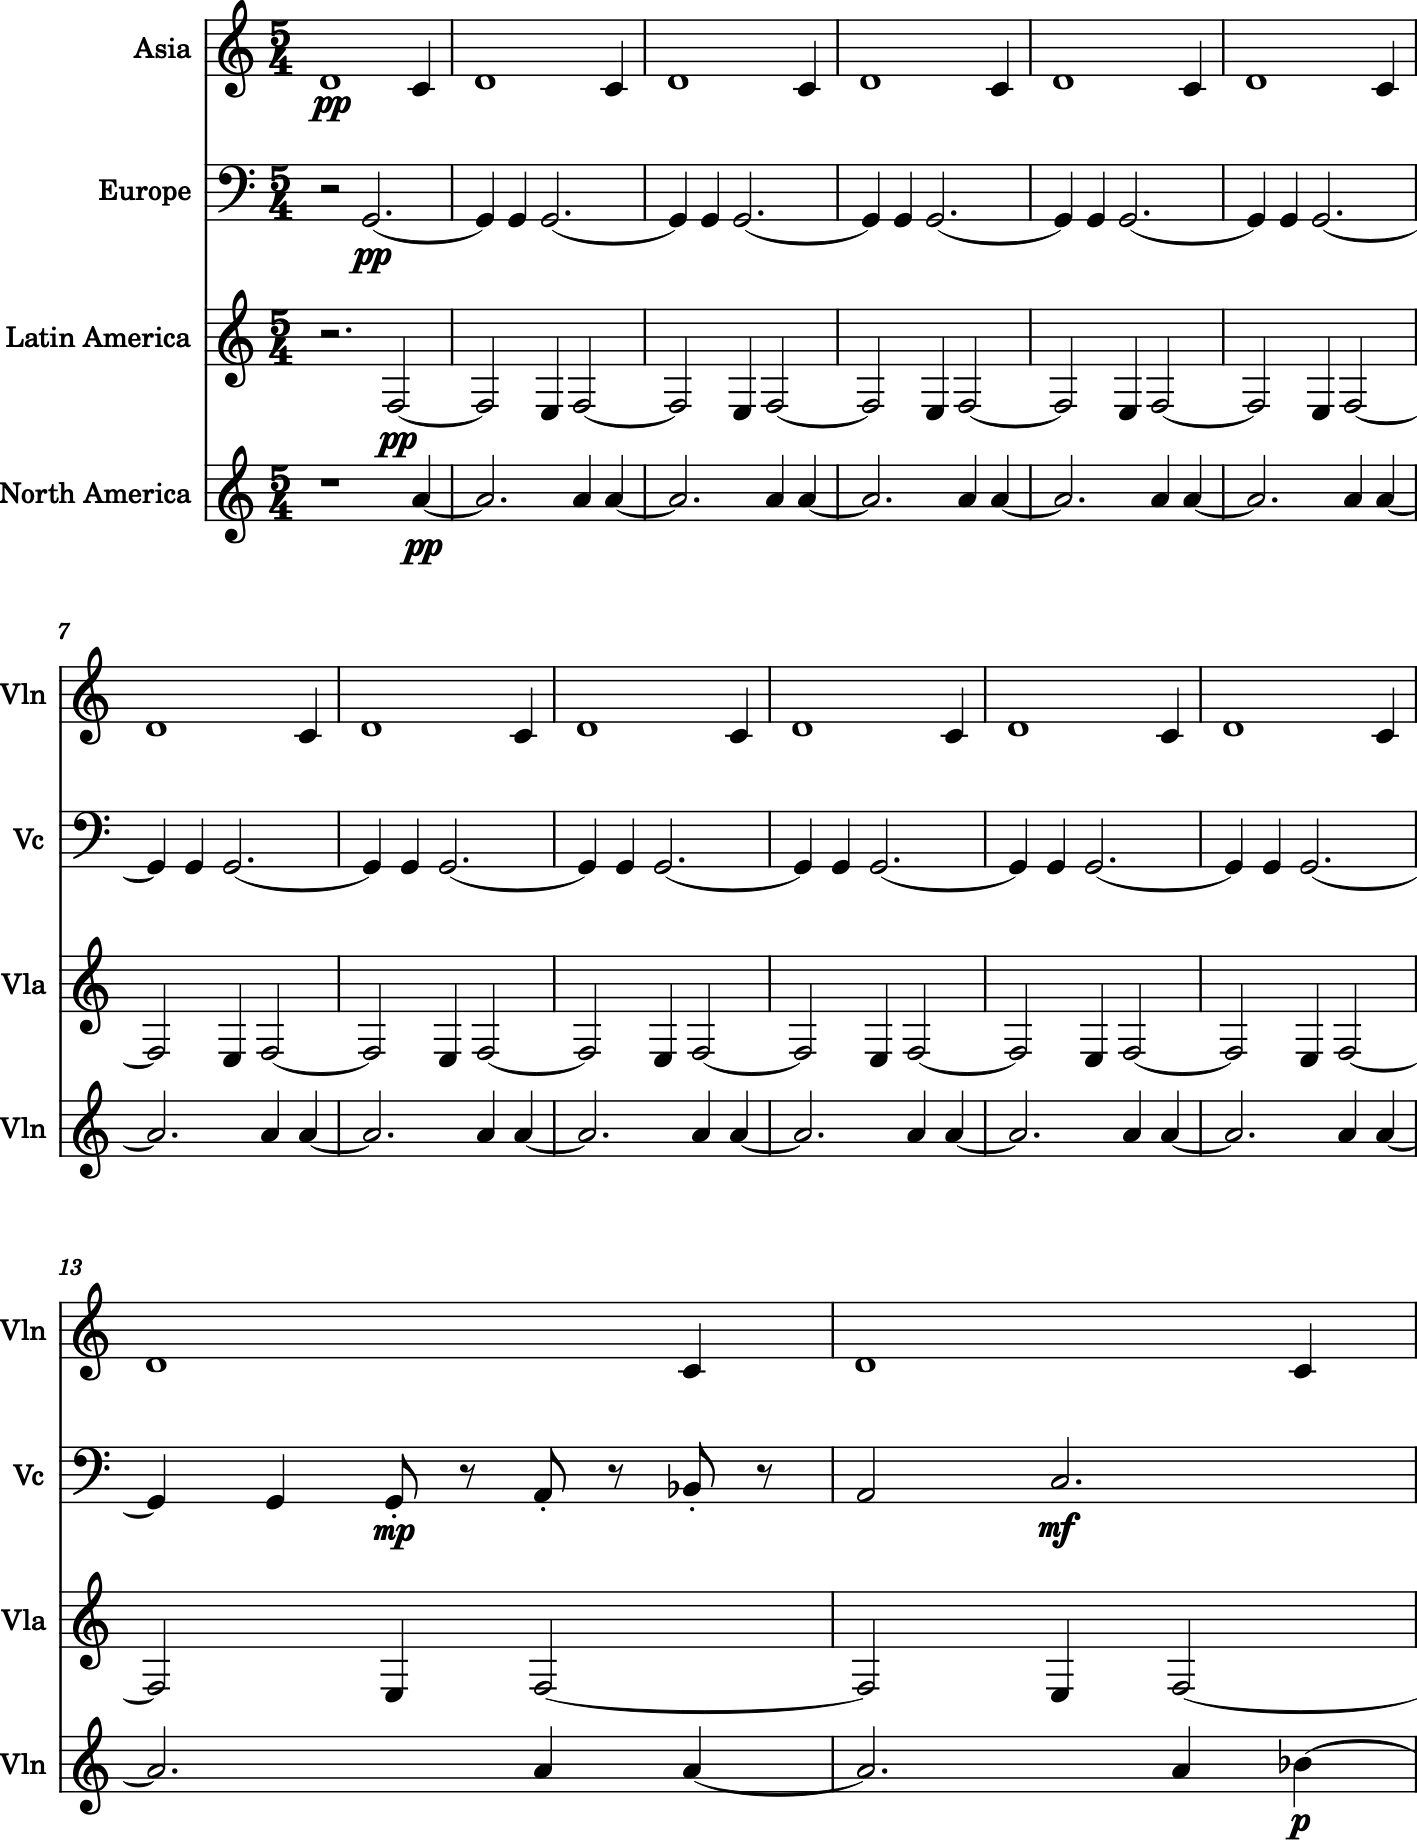

In [125]:
c.show()